# PixelCNN for FashionMNIST

### In progress

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [13]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms as Transforms
import torchvision.utils as vuitls

import torchinfo

## 0. Train Parameters

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 32
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Preparing FashionMNIST dataset

In [3]:
# Turn input image into (label-pixel representatin, pixel-wise labels)
def collate_fn(batch):
    batch = torch.stack([data[0] for data in batch])
    value_step = 1.0 / PIXEL_LEVELS
    labels = (batch / value_step).type(torch.int)
    imgs = labels.type(torch.float32) * PIXEL_LEVELS
    return imgs, labels

transform_fn = Transforms.Compose([
                    Transforms.ToTensor(),
                    Transforms.Resize(IMAGE_SIZE, antialias=True),                        
                ])

# Load FashionMNIST dataset
fashion_ds = datasets.FashionMNIST('../../data', 
                                  train=True, 
                                  download=True,
                                  transform=transform_fn)

# Get train dataloader
train_loader = DataLoader(fashion_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn)

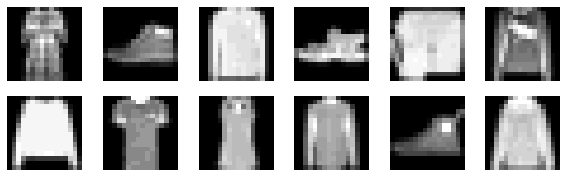

In [4]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(batch[i].permute(1, 2, 0), cmap='gray')
        ax.axis('off')
    plt.show()
        
sample_data = next(iter(train_loader))
plot_imgs(sample_data[0])

## 2. Build the PixelCNN

This PyTorch implementation references pi-tau's GitHub repo: [Link](https://github.com/pi-tau/pixelcnn/blob/master/conv2d_mask.py)

In [18]:
class MaskedConv2D(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        kwargs['padding'] = 'same'
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)

        assert mask_type in ['A', 'B'], 'Mask type should be either A or B'
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # Creating masks
        kh, kw = kernel_size
        mask = torch.ones_like(self.weight)
        mask[:, :, (kh // 2 + 1):, :] = 0
        mask[:, :, (kh // 2), (kw // 2 + 1):] = 0
        # If mask type is A, then masking the center pixel
        if mask_type == 'A':
            mask[:, :, (kh // 2), (kw // 2)] = 0

        # Making the mask the non-trainable parameter of the module
        self.register_buffer('mask', mask.type(dtype=torch.bool))

    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, self.bias, 
                        self.stride, self.padding)

Check the mask in the masked conv layer

In [37]:
test_conv_layer = MaskedConv2D('A', 1, 1, 5)
print("Mask of the conv layer: \n", test_conv_layer.mask)

Mask of the conv layer: 
 tensor([[[[ True,  True,  True,  True,  True],
          [ True,  True,  True,  True,  True],
          [ True,  True, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]]]])
